# 비대칭 데이터 문제

클래스의 비대칭이 심한 경우(highly-imbalnaced data) 분류 모델이 단순하게 다수 클래스를 선택하는 경향이 발생한다.

titanic 데이터의 경우 남녀 생존비율이 2:8인데 단순히 남성이면 사망이라고 판단해도 그 정확도는 약 80%가 된다.
    
따라서 이 비대칭 데이터의 경우 정확도는 높지만 전체 데이터에서 실제로 양성을 검출해낸 recall-rate은 급격히 작아지는 현상이 발생할 수 있다.

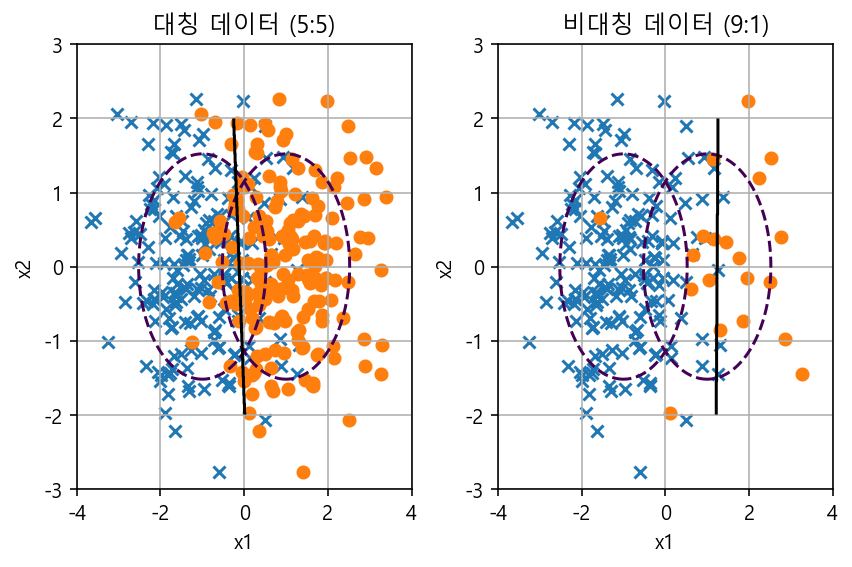

In [34]:
from sklearn.datasets import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.svm import SVC
import scipy as sp

def classification_result(n0, n1, title=""):
    rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
    rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
    X0 = rv1.rvs(n0, random_state=0)
    X1 = rv2.rvs(n1, random_state=0)
    X = np.vstack([X0, X1])
    y = np.hstack([np.zeros(n0), np.ones(n1)])

    x1min = -4; x1max = 4
    x2min = -2; x2max = 2
    xx1 = np.linspace(x1min, x1max, 1000)
    xx2 = np.linspace(x2min, x2max, 1000)
    X1, X2 = np.meshgrid(xx1, xx2)

    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")

    model = SVC(kernel="linear", C=1e4, random_state=0, probability=True).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    
    return model, X, y, y_pred
    
plt.subplot(121)
model1, X1, y1, y_pred1 = classification_result(200, 200, "대칭 데이터 (5:5)")
plt.grid()
plt.subplot(122)
model2, X2, y2, y_pred2 = classification_result(200, 20, "비대칭 데이터 (9:1)")
plt.tight_layout()
plt.grid()
plt.show()

위의 두 분류 결과는 SVM을 이용한 결과로 실선이 판별경계선, 타원이 각 클래스의 확률분포를 나타낸다.

두 클래스가 동일한 비율로 5:5로 존재하는 경우 일반적인 분류 결과를 확인할 수 있다.

하지만 비대칭 데이터 9:1 의 경우 판별경계선이 소수 클래스로 밀려나는 것을 확인할 수 있다.

따라서 비대칭 데이터의 경우 SVM의 분류 결과가 직관적으로 비정상적인 것을 확인할 수 있다.

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

print('------------------------------5:5-----------------------------')
print(classification_report(y1, y_pred1))
print('------------------------------9:1-----------------------------')
print(classification_report(y2, y_pred2))

------------------------------5:5-----------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       200
         1.0       0.84      0.86      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400

------------------------------9:1-----------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



하지만 classfication_report를 확인해보면 두 분류 결과의 accuracy는 0.85, 0.95로 오히려 비정상적인 경우의 accuracy가 더 높게 측정되는 것을 확인할 수 있다.

하지만 class_1에 대한 recall_score를 확인해보면 비대칭 데이터의 경우 대칭데이터보다 약 26% 더 낮으며 지나치게 다수 클래스 데이터에 의존하는 모델이 생성된 것을 확인할 수 있다.

하지만 이 문제가 Fraud Detection과 같은 recall_rate을 높여야 하는 문제라면 비대칭 데이터의 분류 결과는 심각한 문제를 초래할 수 있다.


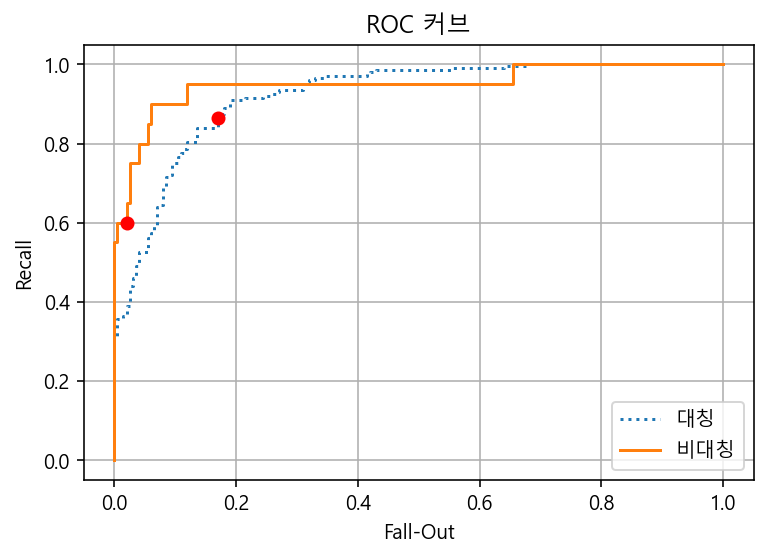

In [10]:
from sklearn.metrics import roc_curve, confusion_matrix

fpr1, tpr1, thresholds1 = roc_curve(y1, model1.decision_function(X1))
fpr2, tpr2, thresholds2 = roc_curve(y2, model2.decision_function(X2))

c1 = confusion_matrix(y1, y_pred1, labels=[1, 0])
c2 = confusion_matrix(y2, y_pred2, labels=[1, 0])
r1 = c1[0, 0] / (c1[0, 0] + c1[0, 1])
r2 = c2[0, 0] / (c2[0, 0] + c2[0, 1])
f1 = c1[1, 0] / (c1[1, 0] + c1[1, 1])
f2 = c2[1, 0] / (c2[1, 0] + c2[1, 1])

plt.plot(fpr1, tpr1, ':', label="대칭")
plt.plot(fpr2, tpr2, '-', label="비대칭")
plt.plot([f1], [r1], 'ro')
plt.plot([f2], [r2], 'ro')
plt.legend()
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('ROC 커브')
plt.grid()
plt.show()

실제로 ROC-Curve를 확인해보면 비대칭 데이터가 더 좋은 성능을 보이는 것으로 보이지만 recall_rate을 확인해보면 문제가 있다는 것을 확인할 수 있다.

따라서 이 경우 threshhold를 낮추어 recall_rate을 높이는 방법을 이용할 수 있다.

# threshold 조정

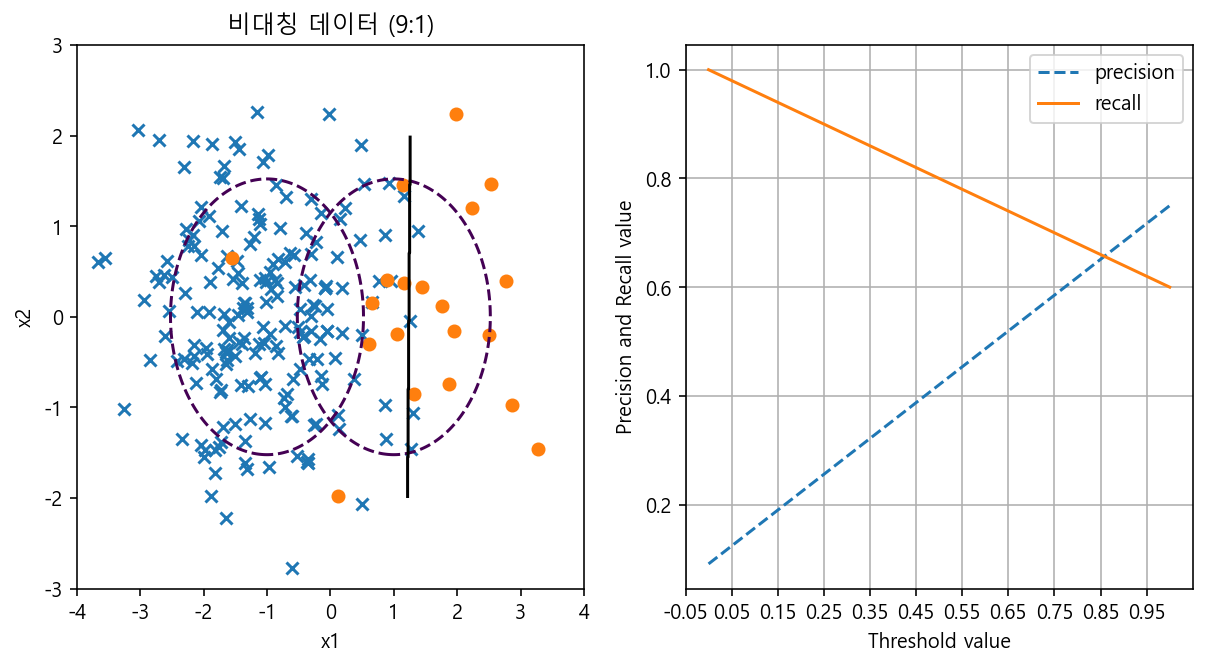

<Figure size 432x288 with 0 Axes>

In [47]:
from sklearn.metrics import precision_recall_curve

# 임계값에 따른 precision, recall 점수 변화 시각화

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.subplot(122)
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
model2, X2, y2, y_pred2 = classification_result(200, 20, "비대칭 데이터 (9:1)")

pred_proba_c1 = model2.predict_proba(X2)[:, 1]

plt.subplot(122)
precision_recall_curve_plot(y2, y_pred2)
plt.tight_layout()
plt.show()

실제로 thresholds가 낮을수록 recall값이 상승하는 것을 확인할 수 있고 ROC-curve와 위의 두번째 그래프를 통해 threshold가 0.15일 때 가장 높은 recall과 accuracy를 확인할 수 있다.

# Under-Sampling

언더 샘플링이란 다수 데이터를 날려버려 두 클래스의 비율을 맞추는 방법론이다.

- `RandomUnderSample`r: random under-sampling method


- `TomekLinks` :Tomek's link method


- `CondensedNearestNeighbour`: condensed nearest neighbour method


- `OneSidedSelection`: under-sampling based on one-sided selection method


- `EditedNearestNeighbours`: edited nearest neighbour method


- `NeighbourhoodCleaningRule`: neighbourhood cleaning rule

## Random Under Sampler

Random Under Sampler는 말 그대로 랜덤하게 다수 클래스 데이터를 일부 제거하는 방법이다.

In [67]:
from imblearn.under_sampling import *

n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])

x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)

def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model

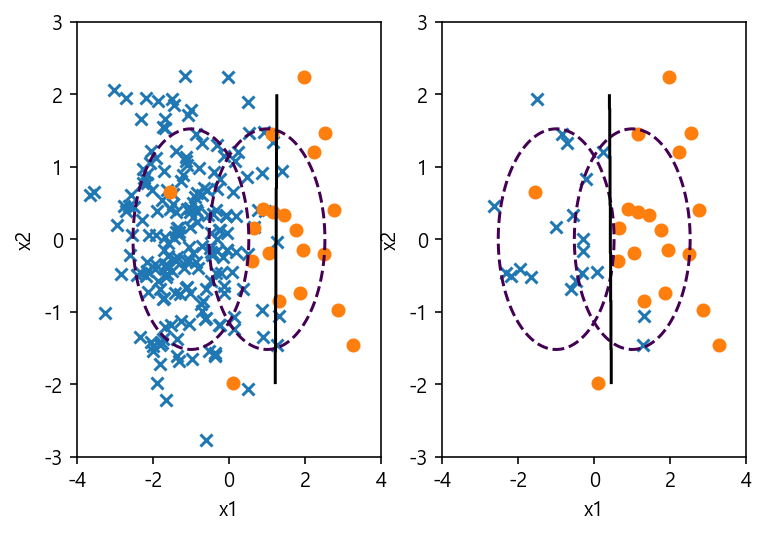

In [68]:
X_samp, y_samp = RandomUnderSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [69]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220



그 결과 판별선이 중앙으로 이동하고 recall 값이 대폭 상승한 것을 확인할 수 있다.

## Tomek's link method

토멕링크는 서로 다른 클래스에 속하는 한 쌍의 데이터($x_+, x_-$)가 서로에게 더 가까운 다른 데이터가 존재하지 않는 것을 말한다.

이 방법은 토멕링크를 찾은 후 다수 클래스에 속하는 데이터를 제외하는 방법이다.

In [86]:
X_imb.shape

(220, 2)

In [90]:
X_rem[0].shape

(220, 2)

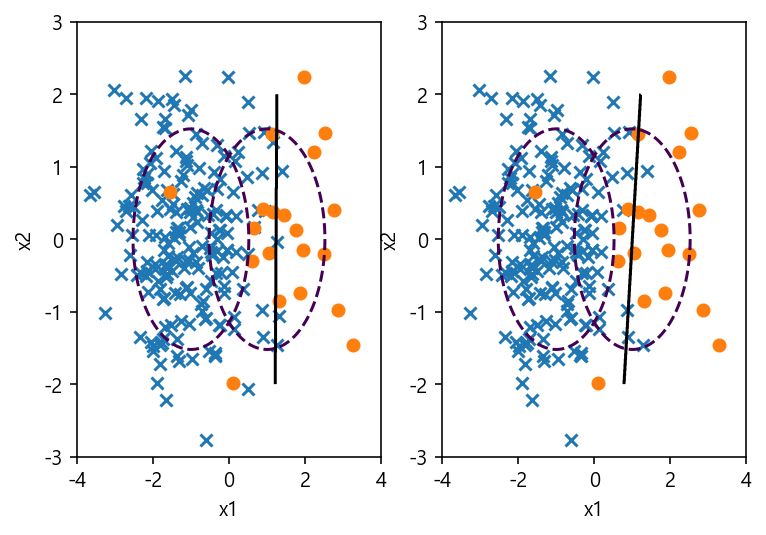

In [93]:
X_samp, y_samp = TomekLinks().fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


In [98]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



## Condensed Nearest Neighbour

CNN방법은 Tomek's link method와는 정반대의 개념으로 이해할 수 있다.

Tomek's link 방법의 경우 토멕링크 중 다수 클래스에 해당하는 데이터를 모두 제거했다. 하지만 CNN방법은 토멕링크에서 제거되는 데이터를 살려 판별선을 그대로 두는 방법이다. 이 원리는 SVM에서 서포트 벡터의 중요성과 같은 개념이다.

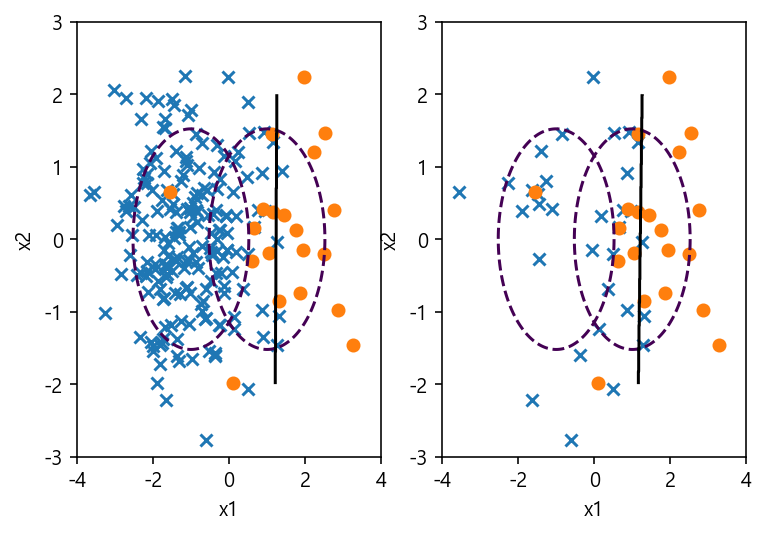

In [99]:
X_samp, y_samp = CondensedNearestNeighbour(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [100]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       200
         1.0       0.75      0.60      0.67        20

    accuracy                           0.95       220
   macro avg       0.86      0.79      0.82       220
weighted avg       0.94      0.95      0.94       220



## One Sided Selection

one sided selection 방법은 토멕링크와 CNN을 합친 방법이다.

이 방법은 토멕링크에서 다수 클래스에 해당하는 데이터를 제거하고 나머지 데이터 중에서도 안쪽 진영에 해당하는 데이터를 제거하는 방법이다.

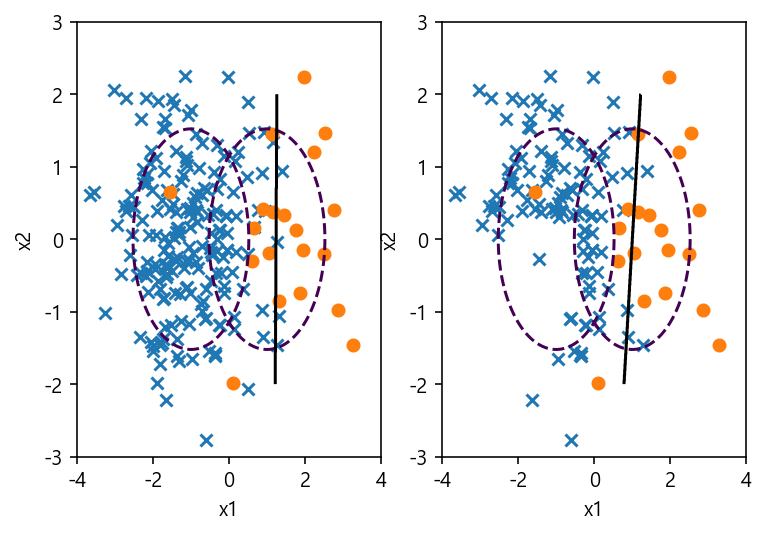

In [101]:
X_samp, y_samp = OneSidedSelection(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [102]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.70      0.70      0.70        20

    accuracy                           0.95       220
   macro avg       0.83      0.83      0.83       220
weighted avg       0.95      0.95      0.95       220



## Edited Nearest Neighbours

ENN 방법은 다수 클래스 데이터 중에서 한개의 데이터가 아닌 K개의 데이터가 모두 다수 클래스가 아니면 삭제하는 방법이다.

즉, 소수 클래스 주변의 다수 클래스 데이터는 제거된다.

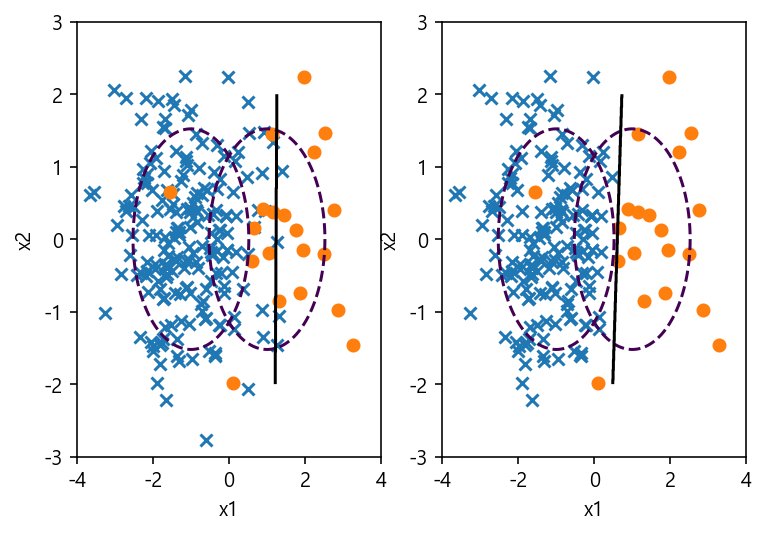

In [104]:
X_samp, y_samp = EditedNearestNeighbours(kind_sel="all", n_neighbors=5).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [105]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96       200
         1.0       0.58      0.90      0.71        20

    accuracy                           0.93       220
   macro avg       0.79      0.92      0.83       220
weighted avg       0.95      0.93      0.94       220



## Neighbourhood Cleaning Rule

Neighbourhood Cleaning Rule 방법은 CNN, ENN을 혼합한 방법이다.

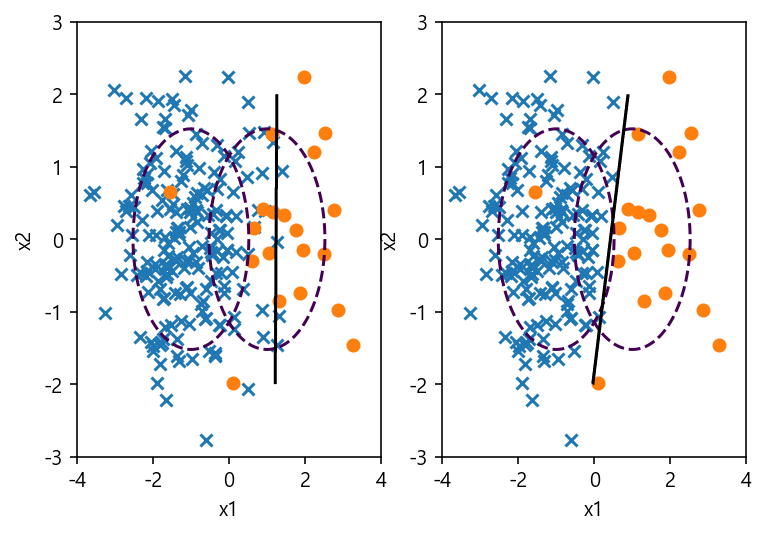

In [106]:
X_samp, y_samp = NeighbourhoodCleaningRule(kind_sel="all", n_neighbors=5).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [107]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       200
         1.0       0.56      0.95      0.70        20

    accuracy                           0.93       220
   macro avg       0.78      0.94      0.83       220
weighted avg       0.96      0.93      0.94       220



# Over-Sampling

- RandomOverSampler: random sampler


- ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning


- SMOTE: Synthetic Minority Over-sampling Technique

In [108]:
from imblearn.over_sampling import *

## RandomOverSampler

RandomOverSampling은 소수 클래스의 데이터를 반복해서 넣는것으로 가중치를 증가시키는 개념이다.

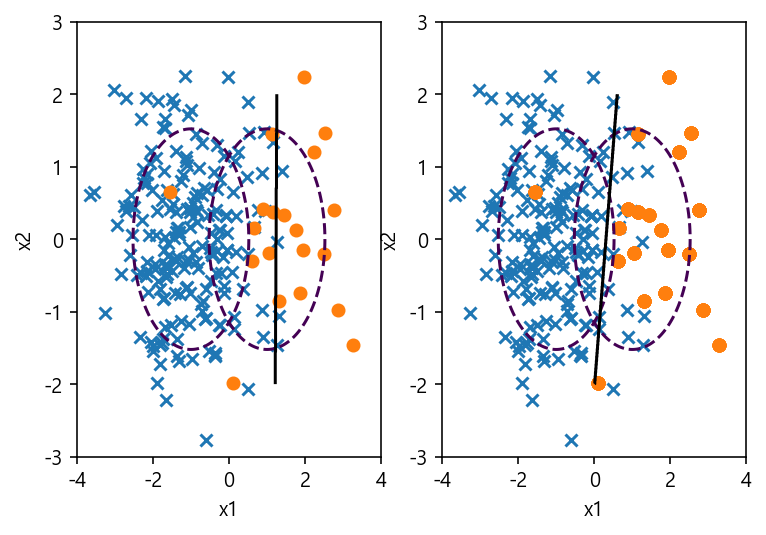

In [109]:
X_samp, y_samp = RandomOverSampler(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

위 그래프 결과에서 사실상 주황색 클래스 데이터는 겹쳐진 2개라고 보면된다.

In [110]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.51      0.95      0.67        20

    accuracy                           0.91       220
   macro avg       0.75      0.93      0.81       220
weighted avg       0.95      0.91      0.92       220



# ADASYN

Adaptive Synthetic Sampling 방법은 소수 클래스 데이터와 그 데이터에서 가장 가까운 K개의 소수 클래스 데이터 중 무작위로 선택된 데이터 사이의 직선상에 새로운 가상의 데이터를 추가하는 방법이다.

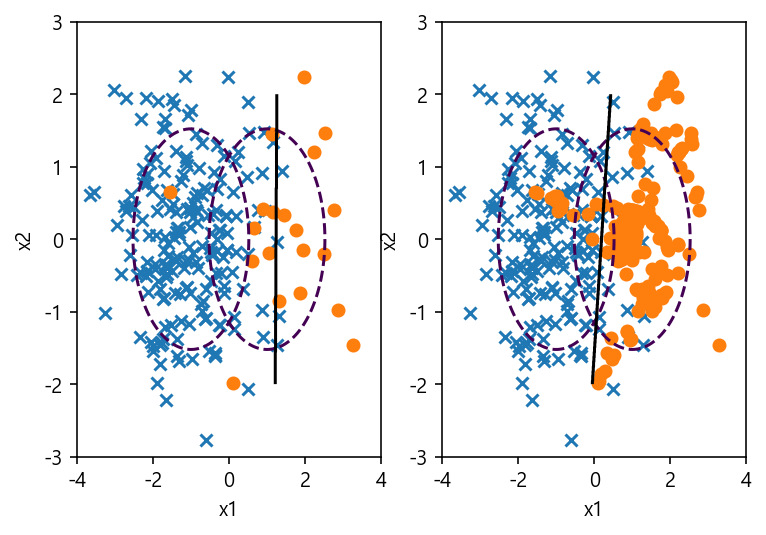

In [111]:
X_samp, y_samp = ADASYN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [112]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94       200
         1.0       0.47      0.95      0.63        20

    accuracy                           0.90       220
   macro avg       0.73      0.92      0.79       220
weighted avg       0.95      0.90      0.91       220



## SMOTE

Synthetic Minority Over-Sampling Technique 방법은 ADASYN 방법과 마찬가지로 가상의 데이터를 생성한다. 하지만 생성된 데이터를 무조건 소수 클래스라고 하지 않고 분류 모형에 따라 분류한다.

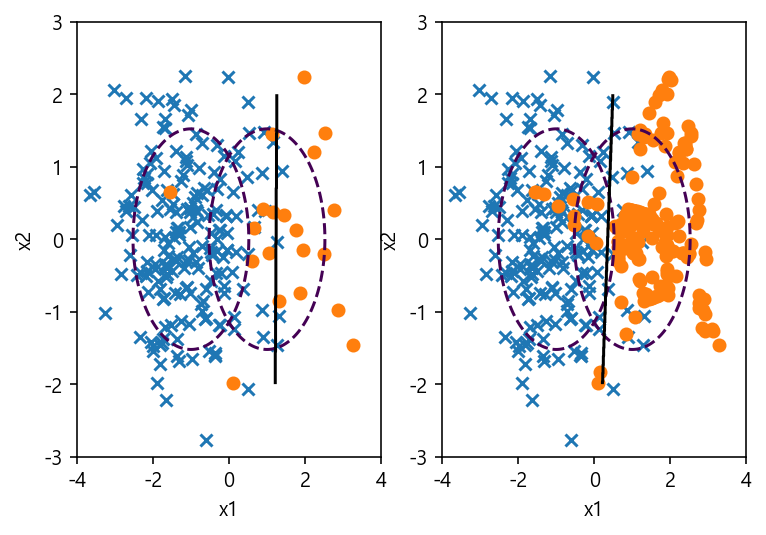

In [113]:
X_samp, y_samp = SMOTE(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [114]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95       200
         1.0       0.50      0.90      0.64        20

    accuracy                           0.91       220
   macro avg       0.74      0.91      0.80       220
weighted avg       0.94      0.91      0.92       220



# 복합 샘플링

- SMOTEENN: SMOTE + ENN



- SMOTETomek: SMOTE + Tomek

In [115]:
from imblearn.combine import *

## SMOTE + ENN

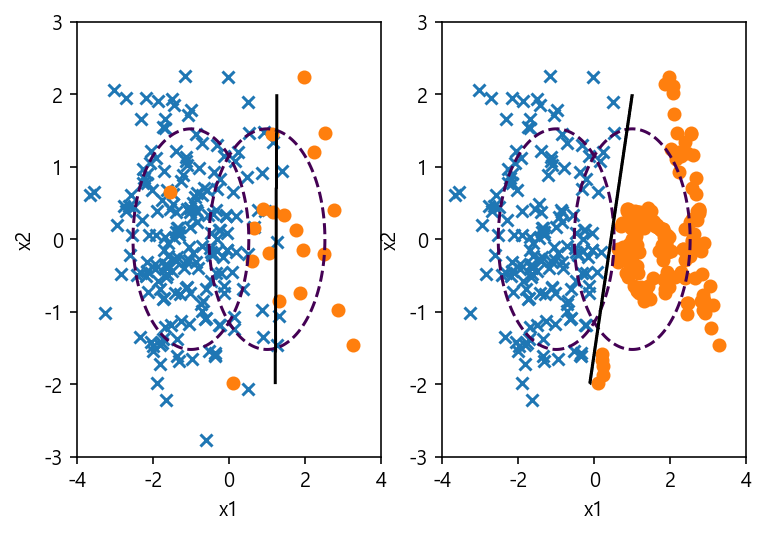

In [116]:
X_samp, y_samp = SMOTEENN(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [117]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       200
         1.0       0.54      0.95      0.69        20

    accuracy                           0.92       220
   macro avg       0.77      0.94      0.82       220
weighted avg       0.95      0.92      0.93       220



## SMOTE+Tomek

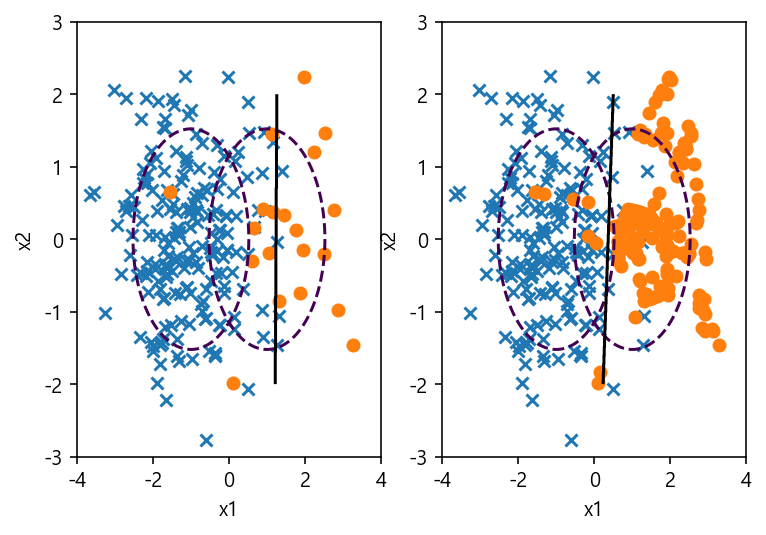

In [118]:
X_samp, y_samp = SMOTETomek(random_state=4).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

In [119]:
print(classification_report(y_imb, model_samp.predict(X_imb)))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       200
         1.0       0.51      0.90      0.65        20

    accuracy                           0.91       220
   macro avg       0.75      0.91      0.80       220
weighted avg       0.95      0.91      0.92       220

